In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

#### 1. Loading and Normalizing MNIST

In [2]:
batch_size = 156

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
trainset = torchvision.datasets.MNIST( '../data', train=True, transform=transform, target_transform=None, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.MNIST( '../data', train=False, transform=transform, target_transform=None, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

#### 2. Visualizing Data

In [5]:
data = iter(trainloader)

In [6]:
images, labels = data.next()

In [7]:
def imshow(img):
    imgnp = img.numpy()
    plt.imshow(imgnp[0])
    plt.show()

#### 3. Defining The Network

In [8]:
class VAE(nn.Module):
    
    def __init__(self, in_features):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(in_features, int(in_features/2))
        self.fc2 = nn.Linear(int(in_features/2), int(in_features/4))
        self.fc31 = nn.Linear(int(in_features/4), 2)
        self.fc32 = nn.Linear(int(in_features/4), 2)
        self.fc4 = nn.Linear(2, int(in_features/4))
        self.fc5 = nn.Linear(int(in_features/4), int(in_features/2))
        self.fc6 = nn.Linear(int(in_features/2), in_features)
    
    def encoder(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc31(x), self.fc32(x)
    
    def reparametrization(self, z_mean, z_log_var):
        z_var = torch.exp(0.5 * z_log_var)
        eps = torch.rand_like(z_var)
        return z_mean + eps*z_var

    def decoder(self, x):
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        return torch.sigmoid(self.fc6(x))
    
    def forward(self, x):
        z_mean, z_log_var = self.encoder(x.view(-1, 28*28))
        z = self.reparametrization(z_mean, z_log_var)
        return self.decoder(z), z_mean, z_log_var

In [9]:
vae = VAE(28*28)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

In [10]:
def vae_loss(x_recon, x, z_mean, z_log_var):
    BCE = F.binary_cross_entropy(x_recon, x.view(-1,28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())    
    return BCE + KLD

#### 4. Training

In [11]:
for epoch in range(20):
    
    running_loss = 0.0
    
    for idx, data in enumerate(trainloader, 0):
        
        image, label = data
        optimizer.zero_grad()
        
        output, z_mean, z_log_var = vae(image)
        loss = vae_loss(output, image, z_mean, z_log_var)
        loss.backward()
        
        running_loss += loss
        
        optimizer.step()
        if idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, idx * len(data),
                len(trainloader.dataset), 100. * idx / len(trainloader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, running_loss / len(trainloader.dataset)))

Train Epoch: 0 [0/60000 (0%)]	Loss: 42561.964844
Train Epoch: 0 [200/60000 (26%)]	Loss: 14207.749023
Train Epoch: 0 [400/60000 (52%)]	Loss: 13586.726562
Train Epoch: 0 [600/60000 (78%)]	Loss: 12587.623047
====> Epoch: 0 Average loss: 184.4951
Train Epoch: 1 [0/60000 (0%)]	Loss: 12500.718750
Train Epoch: 1 [200/60000 (26%)]	Loss: 12442.706055
Train Epoch: 1 [400/60000 (52%)]	Loss: 12502.182617
Train Epoch: 1 [600/60000 (78%)]	Loss: 12097.656250
====> Epoch: 1 Average loss: 158.0859
Train Epoch: 2 [0/60000 (0%)]	Loss: 11944.301758
Train Epoch: 2 [200/60000 (26%)]	Loss: 11640.157227
Train Epoch: 2 [400/60000 (52%)]	Loss: 11903.246094
Train Epoch: 2 [600/60000 (78%)]	Loss: 11848.565430
====> Epoch: 2 Average loss: 152.8383
Train Epoch: 3 [0/60000 (0%)]	Loss: 11573.368164
Train Epoch: 3 [200/60000 (26%)]	Loss: 12110.664062
Train Epoch: 3 [400/60000 (52%)]	Loss: 11719.659180
Train Epoch: 3 [600/60000 (78%)]	Loss: 11783.065430
====> Epoch: 3 Average loss: 149.7673
Train Epoch: 4 [0/60000 (0%)

#### 5. Output

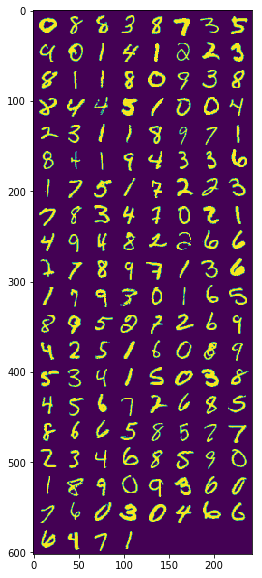

In [12]:
def imshow(img):
    plt.figure(figsize=[20,10])
    imgnp = img.detach().numpy()
    plt.imshow(imgnp[0])
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

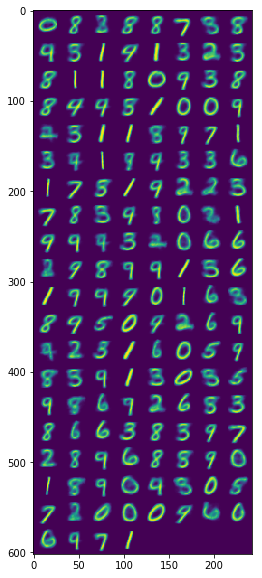

In [13]:
outputs = vae(images)[0].view(batch_size,1, 28,28)

# print images
imshow(torchvision.utils.make_grid(outputs))

In [20]:
def plot_generated_images(decoder):
    """
    Display a 2D plot of the generated images.
    We only need the decoder, because we'll manually sample the
    distribution z
    :param decoder: the decoder network
    """
    # display a nxn 2D manifold of digits
    n = 15
    digit_size = 28
    figure = torch.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    # start sampling z1 and z2 in the ranges grid_x and grid_y
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]])
            x_decoded = decoder(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            slice_i = slice(i * digit_size, (i + 1) * digit_size)
            slice_j = slice(j * digit_size, (j + 1) * digit_size)
            figure[slice_i, slice_j] = digit
    # plot the results
    plt.figure(figsize=(6, 5))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure.detach(), cmap='Greys_r')
    plt.show()

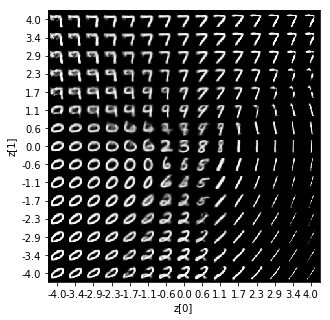

In [21]:
plot_generated_images(decoder=vae.decoder)